In [1]:
from IPython.core.display import HTML
#css_file = '/Users/Luis/numerical-mooc/styles/numericalmoocstyle.css'
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
import numpy
from numpy import pi
#
import sympy
import math
#
import scipy
from scipy import constants
#
import matplotlib.pyplot 
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
#
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

### Domain

In [3]:
def get_domain(Ld,Lg,Lc,n_an, n_gap, n_cath):
    ''' This function obtains the domain based on a 
    cell-centered grid. The domain is divided into three parts:
    (1) anode region, (2) gap, (3) cathode.
    
    Parameters:
    ----------
    Ld: Domain Length
    Lg: gap length
    Lc: cathode length
    n_an: number of boundary nodes in anode
    n_gap: number of boundary nodes in gap
    n_cath: number of boundary nodes in cathode
    
    Returns:
    --------
    '''
    # Dimensions of Domain
    L_chamber = Ld
    L_gap = Lg
    L_cathode = Lc
    L_anode = L_chamber - (Lgap + L_cathode)
    #
    #cell-centered grid approach
    #
    #anode region
    xl_an = 0.0
    xr_an = L_anode
    delx_an = (xr_an-xl_an)/(n_an-1.0)
    xb_an = numpy.linspace(xl_an, xr_an, n_an)
    xc_an = xb_an[:-1]+(delx_an*0.5)
    #
    #gap region
    xl_gap = L_anode
    xr_gap = L_anode+Lgap
    delx_gap = (xr_gap-xl_gap)/(n_gap-1.0)
    xb_gap = numpy.linspace(xl_gap, xr_gap, n_gap)
    xc_gap = xb_gap[:-1]+(delx_gap*0.5)
    #
    #cathode region
    xl_cath = L_anode+Lgap
    xr_cath = L_chamber
    delx_cath = (xr_cath-xl_cath)/(n_cath-1.0)
    xb_cath = numpy.linspace(xl_cath, xr_cath, n_cath)
    xc_cath = xb_cath[:-1]+(delx_cath*0.5)
    #
    xb_t = numpy.concatenate((xb_an, xb_gap[1:-1], xb_cath))
    xc_t = numpy.concatenate((xc_an, xc_gap, xc_cath))
    #
    return delx_an, delx_gap, delx_cath, xb_t, xc_t
#     return delx_an, delx_gap, delx_cath, xb_an, xc_an, xb_gap, xc_gap,\
#                 xb_cath, xc_cath
    

In [4]:
# Domain, Dimensions
L_chamber = 0.24  #meters
Lgap = 0.004 #interelectrode gap [meters]
L_cathode = 0.112
L_anode = L_chamber - (Lgap + L_cathode)
#
nx_anode = 101
nx_cathode = 111
nx_gap = 41

#get cell boundary and cell center locations
dx_a, dx_g, dx_c, xb, xc = get_domain(L_chamber,Lgap,L_cathode,\
                                      nx_anode, nx_gap, nx_cathode)

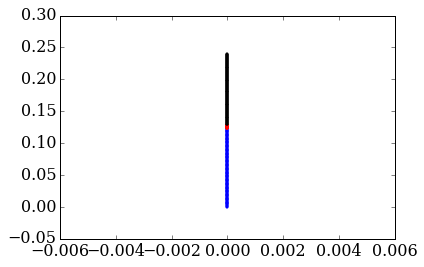

In [5]:
Xc_an = numpy.meshgrid(xc[:100])
Xc_gap = numpy.meshgrid(xc[100:140])
Xc_cathode = numpy.meshgrid(xc[141:])
#
pyplot.scatter(numpy.zeros_like(Xc_an), Xc_an,\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(numpy.zeros_like(Xc_gap), Xc_gap,\
                   s=10, color='r', marker='o', linewidth=0)
pyplot.scatter(numpy.zeros_like(Xc_cathode), Xc_cathode,\
                   s=10, color='k', marker='o', linewidth=0);

##### xc[0:100]  to access anode cell-center nodes
##### xc[100:140] to access gap cell-center nodes
##### xc[140:] to access cathode cell-center nodes

##### xb[0:101] # to access anode boundary nodes
##### xb[101:141] to access gap boundary nodes
##### xb[141:] to access cathode boundary nodes


### Initialization

In [6]:
#Input Current
I_arc = 60.0

#Initialization Variables
gamma1 = 5.0/3.0
gravity = 9.8

# collision radius Carbon-Helium:
cr_C_He = (1.7 + 1.4)

#reference pressure and temperature
T_ref = 3350.0 #Kelvin
P_ref = 300 * 133.322 # torr to Pa

#Constants
Ckb = scipy.constants.k  #Boltzmann Constant J/K
Cme = scipy.constants.m_e #Elementary Electron Mass kg
Ch = scipy.constants.h; # Planck's constant Js

CNA = scipy.constants.N_A #avogadros number

e = scipy.constants.e #elementary charge, C

#Carbon
M_carbon = 12.0e-3/CNA #kg
mC = 12.0 # molar mass g/mol
Ipc1 = 1086.5e3/CNA #J, energy of first ionization
anode_workfunction = 4.7 #eV
emissivity=0.70 #carbon, graphite

#heat of vaporization anode:
dH_C = 710.0e6/mC
#

#Helium
M_helium = 4.0e-3/CNA # kg
mHe = 4.0 #molar mass, g/mol
Ipg1 = 2372.3e3/CNA; # J, energy of first ionization
#              

##### anode and cathode

In [7]:
def electrodes_initial(xp_an, xp_cath):
    ''' This function assigns the initial
    thermophysical properties for electrodes
    
    Parameters:
    ------------
    xp: node locations for anode, cathode
    mu: viscosity
    kp: thermal conductivity
    
    
    '''
    xC = 1.0 #molar fraction, pure carbon material
    wC = 1.0 # mass fraction, pure carbon material
    #dynamic viscosity
    mu_an = numpy.zeros_like(xp_an)
    mu_cath = numpy.zeros_like(xp_cath)
    #
    mu_an[:] = 10. #
    mu_cath[:] = 10.
    # thermal conductivity
    kp_an = numpy.zeros_like(xp_an)
    kp_cath = numpy.zeros_like(xp_cath)
    #
    kp_an = 110.0 # W/(m K)
    kp_cath = 110.0 #W/(m K)
    # density
    rho_an = numpy.zeros_like(xp_an)
    rho_cath = numpy.zeros_like(xp_cath)
    #
    rho_an[:] = 2267.0*xC #kg/m3
    rho_cath[:] = 2267.0*xC
    # diffusion coefficient
    D_an = numpy.zeros_like(xp_an)
    D_cath = numpy.zeros_like(xp_cath)
    #
    D_an[:] = 100.0 #m2/s
    D_cath[:] = 100.0
    #specific heat
    cp_an = numpy.zeros_like(xp_an)
    cp_cath = numpy.zeros_like(xp_cath)
    #
    cp_an[:] = 710. #J/(Kg-K)
    cp_cath[:] = 710.0
    # temperature
    T_an = numpy.zeros_like(xp_an)
    T_cath = numpy.zeros_like(xp_cath)
    #
    T_an[:] = 300.0 #K
    T_cath[:] = 300.0
    #
    return mu_an, mu_cath, kp_an, kp_cath, rho_an, rho_cath, D_an, D_cath,\
            cp_an, cp_cath, T_an, T_cath

In [8]:
mu_a, mu_c, k_a, k_c, rho_a, rho_c, D_a, D_c, cp_a, cp_c, T_a, T_c = \
    electrodes_initial(xc[0:100], xc[141:])

##### gap

In [9]:
def gap_initial(cs1,ms1,ms2, xp, I_current):
    ''' Finds molar mass of mixture in 1D domain at every node in gap
    
    Parameters:
    ----------
    cs1: Concentration of species 1
    ms1: molar mass of species 1
    ms2: molar mass of species 2, background gas if only 2 species
    xp: number of nodes in domain
    
    
    '''
    m_mix = numpy.zeros_like(xp)
    R_mix = numpy.zeros_like(xp)
    mu_gap = numpy.zeros_like(xp)
    k_gap = numpy.zeros_like(xp)
    rho_gap = numpy.zeros_like(xp)
    cp_gap = numpy.zeros_like(xp)
    T_gap = numpy.zeros_like(xp)
    e_cond_He = numpy.zeros_like(xp)
    ne_gap = numpy.zeros_like(xp)
    P_gap = numpy.zeros_like(xp)
    #
    c1 = numpy.ones_like(xp)*cs1
    #
    #molar mass of mixture
    m_mix[:] = 1.0/( (c1[:]/ms1) + ((1.0-c1[:])/ms2) )
    #specific gas constant of mixture
    R_mix[:] = (scipy.constants.R/m_mix[:])*1000 
    #viscosity of mixture
    mu_gap[:] = 19e-6
    #thermal conductivity of mixture
    k_gap[:] = 0.15
    #density of mixture:
    rho_gap[:] = 0.109486
    #specific heat of mixture:
    cp_gap[:] = 5000.0
    #Temperature of gap:
    T_gap[:] = 300.0
    #electrical conductivity:
    e_cond_He[:] = I_current # or try 0.00001
    #number density:
    ne_gap[:] = 1e6
    #Pressure:
    P_gap[:] = rho_gap[:]*R_mix[:]*(T_gap[:] + ne_gap[:]*Ckb*T_gap[:])
    #
    return m_mix, R_mix, mu_gap, k_gap, rho_gap, cp_gap, T_gap, e_cond_He,\
            ne_gap, P_gap

In [10]:
mol_mass_g, R_g, mu_g, k_g, rho_g, cp_g, T_g, e_cond_g, ne_g, P_g =\
    gap_initial(1.0e-14, mC, mHe, xc[100:140], I_arc)


In [11]:
def get_cp_avg(numx):
    '''Function obtains the specific heat of carbon and helium
    as a function of temperature
    
    Parameters:
    -----------
    T: current temperature in domain
    numx: number of iterations to store
    
    Returns:
    ---------
    '''
    cpAve1 = numpy.zeros((numx))
    cpAve4 = numpy.zeros((numx))
    Ti = numpy.zeros((numx))
    cp1i = numpy.zeros((numx))
    cp4i = numpy.zeros((numx))
    #
    Ti[0] = 0.0

    cp1i[0] = 2100.0 + (Ti[0]-300.0)*0.1
    cp4i[0] = 7.3489e-17*(Ti[0]**5) - 1.201e-12*(Ti[0]**4) -\
                7.448e-10*(Ti[0]**3) + 8.6509e-5*(Ti[0]**2) - 0.34052*Ti[0] + 5351.7
    #    
    cpAve1[0] = cp1i[0]
    cpAve4[0] = cp4i[0]
    #  
    Tim1 = Ti[0]
    #
    for i in range(1,numx):
        #
        Ti[i] = Tim1+100.0
        #
        cp1i[i] = 2100.0 + (Ti[i]-300.0)*0.1
        cp4i[i] = 7.3489e-17*(Ti[i]**5) - 1.201e-12*(Ti[i]**4) -\
                7.448e-10*(Ti[i]**3) + 8.6509e-5*(Ti[i]**2) - 0.34052*Ti[i] + 5351.7
        #
        if (cp4i[i] > 70000.0):
            cp4i[i] = 70000.0;
        if (cp4i[i] < 5000.0):
            cp4i[i] = 5000.0;
        #
        cpAve1[i] = (cpAve1[i-1]*Tim1 +\
                     (cp1i[0]+cp1i[i])/2.0*(Ti[i] - Tim1))/Ti[i]
        cpAve4[i] = (cpAve4[i-1]*Tim1 + (cp4i[0]+cp4i[i])/2.0*(Ti[i] - Tim1))/Ti[i]
        #
        cp1im1 = cp1i
        cp4im1 = cp4i
        #
        Tim1 = Ti[i]
        
    return Ti, cp1i, cpAve1, cp4i, cpAve4

In [12]:
T_i, cp_C_i, cp_C_avg, cp_He_i, cp_He_avg = get_cp_avg(300)

In [ ]:
#electric potential equation 
counter = 0

while(toterror > EMAXi)
    #
    counter +=1
    toterror = 0.0
    for(j = anode_len+2; j<=NZ-cathode_len; j++)
    #
        electricpotential(j);
        TDMA(row_st[j],cathode_wid+1,j,choice)
        toterror = toterror + error;
     
    toterror = sqrt(toterror/((NR-1)*(NZ-1)))
    #
    j = anode_len+1
    phi[j] = phi_ase
    #
    j = NZ-cathode_len+1;
    phi[i][j] = phi_cathode
    #
    for(j=anode_len+1; j<=NZ-cathode_len+1; j++):
        phi[i][j] = phi[i-1][j]

In [ ]:
# run for a test case of 60 amps
#
Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
#
I_arc = 60.
j_arc = I_arc/(pi*Rc**2)

#surface area of anode
R_an = 6.35/2. * 1./1000.  #anode radius [meters]
A_an = pi*(R_an**2)
#
# molar mass
mol_mass_c = 12.0e-3 #kg/mol
mol_mass_he = 4.0e-3
#
mol_mass_c_2 = 12.0 #g/mol
mol_mass_he_2 = 4.0
#
#Specific gas constants
R_C = scipy.constants.R/(mol_mass_c ) #J/(kg-K)
R_He = scipy.constants.R/(mol_mass_he )
R_total = scipy.constants.R/(mol_mass_c + mol_mass_he )
#
#gravity:
g = 9.81

#Electric Potential at cathode
p_c = 23.66 #volts

#ION MASS
UAMU = 1.660538921e-27 # Unified atomic mass unit in Kg

mi_He = UAMU*4.002602
mi_C = UAMU*12.0107

m_i_AMU = (mi_He + mi_C) # given in kilograms

In [ ]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    '''
    
    return numpy.sqrt(numpy.sum((p_new[:] - p_old[:])**2)/numpy.sum(p_old[:]**2))

### Initialize Potential and Current

In [ ]:
def get_phi_init(xp):
    '''Initializes potential field
    ''' 
    p = numpy.zeros_like(xp)
    #
    return p  

In [ ]:
def get_initial_potential(p, l2_target, jx, sigma, delx, phi_cathode):
    '''Use jacobi to solve for potential
    
    Notes:
    1. constant electric potential is considered at the cathode, and
    2. uniform current flux is considered at anode
    
    ''' 
    #
    l2_norm = 1.1 + l2_target #want to make sure this is high enough!
    iterations = 0
    l2_err = []
    itermax = 100000
    
    while l2_norm > l2_target:
        #
        pk = p.copy()
        p[1:-1] = 0.5* (pk[2:] + pk[:-2])
        #
        #Boundary Conditions
        p[0] = pk[1] - ((jx*delx)/sigma)
        p[-1] = phi_cathode
        #
        l2_norm = L2_error(p,pk)
        iterations += 1
        l2_err.append(l2_norm)
        #
        if iterations>itermax:
            print('max iterations reached')
            break
    #
    return p, iterations, l2_err

In [ ]:
p_init = get_phi_init(x.copy())

In [ ]:
phi, itern, l2err = get_initial_potential(p_init.copy(), l2_tar, 60., j_arc, dx, p_c )

In [ ]:
def xy_plot(xp, Uv, labl1, labl2):
    pyplot.figure(figsize=(8,5))
    pyplot.grid(True)
    pyplot.xlabel(labl1, fontsize=18)
    pyplot.ylabel(labl2, fontsize=18)
    pyplot.plot(xp, Uv, color='k', ls='--', lw=2);

In [ ]:
xy_plot(x,phi,'Lgap (m)', 'potential $\phi$ in Volts' )

In [ ]:
def get_current(p, delx, sigma):
    '''Finds current from electric potential
    '''
    #
    j = numpy.zeros_like(p)
    #
    j[1:-1] = (sigma)*((phi[2:]-phi[1:-1])/(2*delx))
    j[0] = (sigma)*((phi[2]-phi[0])/(2*delx))
    j[-1] = (sigma)*((phi[-1]-phi[-3])/(2*delx))
    #
    return j

In [ ]:
j_current = get_current(phi.copy(), dx, j_arc)

In [ ]:
xy_plot(x,j_current/j_arc, 'Lgap (m)', ' Normalized Current Density A/m2' )

### Initial Temperature

In [ ]:
def get_P_and_T_initial(P_chamber,T_chamber, xp, M_bg):
    ''' Use equation of state to find initial temperature
    Parameters:
    ------------
    P_chamber: Initial chamber pressure in scalar form
    T_chamber: Initial chamber temperature (scalar)
    M_bg: background gas molar mass
    '''
    P_i = numpy.zeros_like(xp)
    T_i = numpy.zeros_like(xp)
    rho_i = numpy.zeros_like(xp)
    #
    P_i[:] = P_chamber
    T_i[:] = T_chamber
    #
    rho_i[:] = P_i[:]/(T_i[:]*(scipy.constants.R/M_bg))
    #
    return P_i, T_i, rho_i

In [ ]:
Pi, Ti, ri = get_P_and_T_initial(P_exp, 288.15, x, mol_mass_he)

### electrical conductivity function. to initialize assume sigma = I_arc.

In [ ]:
def get_electrical_conductivity(ne_s, no_s, T):
    #------------------------------------------ 
    #Parameters for Collisions
    re = 2.8179403267e-15 # classical electron radius in meters
    gamma = numpy.exp(0.577) #from Euler's constant
    Qm = 40e-20 #collision cross-section [meters]
    #------------------------------------------
    ni_C = ne_s.copy() #plasma quasi-neutrality
    Te = T.copy()
    #------------------------------------------
    ke = numpy.zeros_like(Te)
    lnA = numpy.zeros_like(Te)
    v_eo = numpy.zeros_like(Te)
    v_ei = numpy.zeros_like(Te)
    ve_t = numpy.zeros_like(Te)
    sigma = numpy.zeros_like(Te)
    #-------------------------------------------
    ke[:] = numpy.sqrt((4*numpy.pi*ne_s[:]*(constants.e**2))/(Te[:]*constants.k))

    lnA[:] = numpy.log((4*constants.k*Te[:])/((gamma**2)*(ke[:])*(constants.e**2))) -\
            2*numpy.log(numpy.sqrt(2))

    # electron-neutral collision frequency
    v_eo[:] = (4/3)*numpy.sqrt((8*constants.k*Te[:])/(pi*constants.m_e))*\
                    Qm*(no_s[:])

    # electron-neutral collision frequency
    v_ei[:] = (4/3)*numpy.sqrt(2*pi)*(ni_C[:])*\
                (((constants.e**2)/(constants.k*Te[:]))**2)*\
                numpy.sqrt((constants.k*Te[:])/constants.m_e)*lnA[:]
    # total collisions
    ve_t[:] = v_ei[:] + v_eo[:]
    #
    # electrical conductivity:
    sigma[:] = (ne_s[:]*constants.e**2)/(constants.m_e* ve_t[:])
    #
    return sigma

### Get thermophysical properties based on current temperature

In [ ]:
def get_diffusivity(Q, Ma, Mb, P, T):
    #
    Dab = numpy.zeros_like(P)
    #
    Dab = (2.63e-7/(P*(Q**2)))*numpy.sqrt((T**3)*(Ma+Mb)/(2*Ma*Mb))
    Dab = Dab*(.01**2)
    #
    return Dab

In [ ]:
Qm = 0.5*(2.2e-10+2.2e-10 )#meters 

# http://www.umich.edu/~elements/fogler%26gurmen/html/03chap/html/collision/index.htm

In [ ]:
Di= get_diffusivity(2.2, mol_mass_c_2, mol_mass_he_2, 0.394737, 288.15)
Di

### get k, mu, cp and gamma from literature

### get ablation rate

In [ ]:
def get_abl_vel(Ta, mi, Aan):
    #
    A = 15.73
    B = 40030.0
    #
    Pv = 0.133*numpy.exp(2.3*(A - B/Ta))
    #
    abl = Pv*numpy.sqrt(mi/(2*pi*scipy.constants.k*Ta))*Aan #kg/(s)
    #
    return abl

In [ ]:
abl_init= get_abl_vel(288.15, m_i_AMU, A_an)
abl_init

In [ ]:
scipy.constants.N_A

In [ ]:
scipy.constants.h

In [ ]:
def mass_diffusion():
    

### Initial Conditions for NS equations

In [ ]:
def get_U_initial(numx, rho_bg, T_start, cp_start, gamma_start, c_abl):
    ''' Finds initial conditions 
    Parameters:
    -----------
    numx: nodes
    rho_abl: density of ablated material
    vel_abl: velocity of ablated material
    P_abl: Pressure of ablated material
    
    return:
    -------
    U_start: Initialize flow field
    '''
    #
    U_start = numpy.zeros((3, numx), dtype=float) #mass, mom, energy
    h_start = numpy.zeros_like(rho_bg)
    #
    #
    U_start[0,:] = (rho_bg)
    #
    U_start[1,:] = (rho_bg)*c_abl
    #
    h_start = cp_start*T_start
    U_start[2,:] = (rho_bg*h_start)/gamma_start
    #
    return U_start

In [ ]:
Ui_test = get_U_initial(nx, ri, Ti, cp_he_std, 1.4, 0.0)

### Boundary Conditions for NS equations

In [ ]:
def get_BC(Uv, rho_abl, rho_bg, abl, Ta, Tc):
    ''' Finds boundary conditions for anode, cathode 
    Parameters:
    -----------
    Uv: vector of mass, mom, energy [3, no. of nodes]
    
    return:
    Ubc: solution field with boundary conditions
    ''' 
    Ubc = Uv.copy()
    #
    # Anode Region
    Ubc[0,0] = # at anode tip (vapor density + gas density)
    Ubc[1,0] = abl #momentum
    Ubc[2,0] = Uv[2,0] #Energy

    # Cathode Region
    Ubc[0,-1] = 2*(Uv[0,-2]) - Uv[0,-3]#interpolate from interior points
    #Ubc[1,-1] = 0.0 #m/s, no flux through boundaries
    Ubc[1,-1] = 2*(Uv[1,-2]) - Uv[1,-3]#interpolate from interior points
    #Ubc[2,-1] = (2*(Uv[0,-2]) - Uv[0,-3])*cp*Tc#interpolate from interior points
    Ubc[2,-1] = 2*(Uv[2,-2]) - Uv[2,-3]
    return Ubc

In [ ]:
def Maccormack(U_init, numt, numx, delt, delx):
    """
    Parameters:
    -----------
    U_init - initial values of mass, momentum, and pressure
    numt - number of time steps
    delt - time step size
    delx - uniform node spacing
    numx - number of nodes

    """
    Un = numpy.zeros((numt+1,3,numx))
    Un[:,:,:] = U_init.copy()
    #
    Us = numpy.zeros_like(U_init)
    Us = U_init.copy()
    #
    U = numpy.zeros((3,numx))
    U = U_init.copy()
    #
    for t in range(1,numt+1):
        #--------------
        # Thermophysical Properties:
        #
        get_temperature(U)
        get_ionization(T_field)
        get_thermal_conductivity(T_field)
        get_viscosity(T_field)
        get_electrical_conductivity(T_field)
        get_specific_heat(T_field)
        #---------------
        #---------------
        # Sublimation
        #
        get_sublimation_rate(Pvapor, Tan)
        #---------------
        #---------------
        # Solve Potential and current density
        get_potential(sigma,)
        get_current_density(phi,)
        #----------------
        #
        # SOLVE NAVIER STOKES:
            #---------------
            #predictor step
        Fs = get_flux(U) 
        S = get_source(U, g,j_arc,sigma)
        #
        Us[:,1:-1] =
            #update Bc on Ustar:
        Us = get_BC()
            #---------------
            #corrector step:
        F = get_flux(Us)
        S2 = get_source(Us, g, j_arc , sigma)
        #
        Un[t,:,1:-1] = 0.5*( U[:,1:-1] + Us[:,1:-1] -\
                            (delt/delx)*(E2[:,1:-1] - E2[:,:-2]) -\
                            (delt/delx**2)*(F2[:,2:] - 2*F2[:,1:-1] + F2[:,:-2]) #+\
                            #S2[:,1:-1] )
        #update BCs
        Un[t,:,:] = get_BC( Un[t,:,:], rho_v, rho_He, ABL, T_an, T_c)
        #
        U = Un[t,:,:].copy()
        #--------------------
        # Residual:
        residnorm = numpy.sum(Un[t,2,:]) + numpy.sum(F) - S
                            
        
        #
#         if ( residnorm < 1e-8) == True ):
#             print('steady state reached')
#             break
    #
    return Un

### Ablation Rate and Ejection Velocity

In [ ]:
def get_abl_vel(Ta, mi, Aan, rho):
    #
    A = 15.73
    B = 40030.0
    #
    Pv = 0.133*numpy.exp(2.3*(A - B/Ta))
    #
    abl = Pv*numpy.sqrt(mi/(2*pi*scipy.constants.k*Ta)) #kg/(m2s)
    #
    vel = abl/(rho) #m/s
    #
    return abl, vel

##### Initial ablation and velocity should be zero

In [ ]:
ABL, u_vel = get_abl_vel(Ti[0], m_i_AMU, A_an, ri[0])

In [ ]:
ABL

In [ ]:
u_vel

### Species Diffusion

##### For one-species model, we don't worry about mass fraction of species since we only consider 1 species

### Ionization

In [ ]:
E_C = 11.2603*constants.e #ionization energy for carbon in Joules

In [ ]:
def get_ne_s1(T, e_iz, P, numx):
    ''' Use SAHA equation, assume 1-species plasma
    
    Parameters:
    ------------
    T_el: Temperature array of domain
    e_iz: ionization energy of species
    P_total: array of pressure, at each node
    
    return:
    -------
    nes,nos, nis: arrays of number densities (solved at each node)
    '''
    T_el = numpy.zeros_like(T)
    P_total = numpy.zeros_like(P)
    #
    T_el = T.copy()
    P_total = P.copy()
    #create arrays:
    f_c = numpy.zeros_like(T_el)
    nes = numpy.zeros_like(T_el)
    nos = numpy.zeros_like(T_el)
    nis = numpy.zeros_like(T_el)
    # create symbolic variable to solve
    #
    for i in range(numx):
        ne_var = sympy.symbols('ne_var')
        #Saha Eqn
        f_c[i] =  ( ( (2*pi*constants.m_e*constants.k*T_el[i]) / \
                     (constants.h**2) )**(3/2) ) *\
                         numpy.exp( (-e_iz) / (constants.k*T_el[i]))
        #
        ne_var_eqn = sympy.Eq(0, ((ne_var**2 )/f_c[i]) + (2*ne_var) -\
                          (P_total[i]/(T_el[i]*constants.k)) )
        #solve for number density:
        nes[i] = sympy.solve(ne_var_eqn, ne_var)[1]
        nos[i] = (nes[i]**2)/f_c[i]
        nis[i] = nes[i]
    #
    return nes, nos, nis

In [ ]:
ne, no, ni = get_ne_s1(Ti.copy(), E_C, Pi.copy(), nx)

### Update Electrical Conductivity

In [ ]:
def get_electrical_conductivity(ne_s, no_s, T):
    #------------------------------------------ 
    #Parameters for Collisions
    re = 2.8179403267e-15 # classical electron radius in meters
    gamma = numpy.exp(0.577) #from Euler's constant
    Qm = 40e-20 #collision cross-section [meters]
    #------------------------------------------
    ni_C = ne_s.copy() #plasma quasi-neutrality
    Te = T.copy()
    #------------------------------------------
    ke = numpy.zeros_like(Te)
    lnA = numpy.zeros_like(Te)
    v_eo = numpy.zeros_like(Te)
    v_ei = numpy.zeros_like(Te)
    ve_t = numpy.zeros_like(Te)
    sigma = numpy.zeros_like(Te)
    #-------------------------------------------
    ke[:] = numpy.sqrt((4*numpy.pi*ne_s[:]*(constants.e**2))/(Te[:]*constants.k))

    lnA[:] = numpy.log((4*constants.k*Te[:])/((gamma**2)*(ke[:])*(constants.e**2))) -\
            2*numpy.log(numpy.sqrt(2))

    # electron-neutral collision frequency
    v_eo[:] = (4/3)*numpy.sqrt((8*constants.k*Te[:])/(pi*constants.m_e))*\
                    Qm*(no_s[:])

    # electron-neutral collision frequency
    v_ei[:] = (4/3)*numpy.sqrt(2*pi)*(ni_C[:])*\
                (((constants.e**2)/(constants.k*Te[:]))**2)*\
                numpy.sqrt((constants.k*Te[:])/constants.m_e)*lnA[:]
    # total collisions
    ve_t[:] = v_ei[:] + v_eo[:]
    #
    # electrical conductivity:
    sigma[:] = (ne_s[:]*constants.e**2)/(constants.m_e* ve_t[:])
    #
    return sigma

In [ ]:
sgma = get_electrical_conductivity(ne.copy(), no.copy(), Ti.copy())

In [ ]:
sgma

### Diffusivity as  a function of Temperature

In [ ]:
def get_diffusivity2(k_v, rho_v, cp_v, xp):
    #
    D = numpy.zeros_like(xp)
    #
    D[:] = k_v/(rho_v*cp_v)
    #
    return D

In [ ]:
def get_viscosity(T, To):
    #
    mu_i = 1.9793e-5 #m2/s
    mu = numpy.zeros_like(T)
    #
    mu[:] = mu_i*((T/To)**(3/2))*((To+110.)/(T+110.))
    #
    return mu

In [ ]:
def get_th_conductivity(mu, cp):
    #
    Pr = 2./3.
    k = numpy.zeros_like(mu)
    #
    k[:] = mu[:]*cp[:]/Pr
    #
    return k

In [ ]:
def get_cp(T, h_enth):
    #
    cp = numpy.zeros_like(T)
    #
    cp[:] = h_enth[:]/T[:]
    #
    return cp

In [ ]:
# Df = get_diffusivity(Qm, mol_mass_c, mol_mass_he, Pi, Ti)
# Df

In [ ]:
Df = get_diffusivity2()

In [ ]:
k =0.138#W/mK

### Momentum and Energy Solver to find velocity distribution in field

The problem can be studied using the time-dependent, 1D Navier-Stokes equations with gravity and joule heating. The equations for x momentum, and energy are:

\begin{align}
0 =& \frac{\partial}{\partial t}( \rho ) + \frac{\partial}{\partial x} (\rho u) \nonumber \\
pg =& \frac{\partial}{\partial t}( \rho u ) + \frac{\partial}{\partial x} \bigg[ \rho u^2 + P - \tau_{x} \bigg] \nonumber \\
\frac{j^{2}}{\sigma}=& \frac{\partial}{\partial t}\big(E_{t}-P \big) + \frac{\partial}{\partial x} \bigg[ \big( E_{t}+P \big)u - D_{c} \big(\frac{h}{c_{p}} \big) - k \frac{\partial}{\partial x} \big( \frac{h}{c_p}\big) \bigg] \nonumber \\
\end{align}

In the equations above: 

\begin{align}
D_{c} &= \frac{5jk_{B}}{2e} \nonumber \\
E_{t} &= \rho h \nonumber \\
P &= \rho R T = \rho h \frac{R}{c_p} \nonumber \\
\tau_{x} &= \mu \frac{\partial u}{\partial x} \nonumber
\end{align}

To begin the discretization process, we can express the system of governing equations in vector form:

\begin{equation}
\frac{\partial \textbf{U}}{\partial t} + \frac{\partial \textbf{E}}{\partial x}  = \textbf{S} \nonumber,
\end{equation}

where the vectors $\textbf{U}, \ and \ \textbf{E}$ with mass conservation included are:

$$\textbf{U} = 
\left[ \begin{array}{c}
\rho \\
\rho u \\
\rho h + \rho h \frac{R}{c_p}
\end{array} \right]$$

$$\textbf{E} = 
\left[ \begin{array}{c}
\rho u \\
\rho u^2 + \rho h \frac{R}{c_p} - \tau_x \\
(\rho h - \rho h \frac{R}{c_p})u - D_{c} \big( \frac{h}{c_p} \big) - k \frac{\partial}{\partial x} \big( \frac{h}{c_p}\big)
\end{array} \right] $$ 

In [ ]:
def get_E_flux(Uv):
    ''' Finds flux values 
    Parameters:
    -----------
    Uv: vector of mass, mom, energy [3, no. of nodes]
    
    return:
    --------
    Fv: fluxes
    ''' 
    #
    Ev = numpy.zeros_like(Uv)
    #
    Ev[0,:] = 
    #
    Ev[1,:] = 
    #
    Ev[2,:] = 
    #
    return Ev